# インポート＆定義

In [211]:
import pandas as pd
import numpy as np
import datetime
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import requests
from bs4 import BeautifulSoup
import time
import re
from urllib.request import urlopen
# import optuna.integration.lightgbm as lgb_o
from itertools import combinations, permutations
import matplotlib.pyplot as plt

def preprocessing(results):
    #コピーで書かないとdfを書き換えたらresultsも変わっちゃうよー
    df = results.copy()
     #着順に数字以外の文字列が含まれているものを取り除く
    df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
    df.dropna(subset=['着順'], inplace=True)
    df['着順'] = df['着順'].astype(int)
    
    #性齢を性と年齢に分ける
    df['性'] = df["性齢"].map(lambda x: str(x)[0])
    df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)
    
    #馬体重を体重と体重変化に分ける
    df['体重'] = df["馬体重"].str.split('(', expand=True)[0].astype(int)
    df['体重変化'] = df["馬体重"].str.split('(', expand=True)[1].str[:-1].astype(int)
    
    #データをint,floatに変換
    df['単勝'] = df['単勝'].astype(float)
    
    #不要な列を削除
    df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手'], axis=1, inplace=True)
    
    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
    
    return df

def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train = df.loc[train_id_list].drop(['date'], axis=1)
    test = df.loc[test_id_list].drop(['date'], axis=1)
    return train, test

# class HorseResults:
#     def __init__(self, horse_results):
#         self.horse_results = horse_results[['日付', '着順', '賞金']]
#         self.preprocessing()
#         # self.horse_results.rename(columns={'着順':'着順_ave', '賞金':'賞金_ave'}, inplace=True)
        
#     def preprocessing(self):
#         #コピーで書かないとdfを書き換えたらresultsも変わっちゃうよー
#         df = self.horse_results.copy()
#         #着順に数字以外の文字列が含まれているものを取り除く
#         df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
#         df.dropna(subset=['着順'], inplace=True)
#         df['着順'] = df['着順'].astype(int)

#         df['date'] = pd.to_datetime(df['日付'])
#         df.drop(['日付'], axis=1, inplace=True)
        
#         #賞金のNaNを0で埋めるぞ
#         df['賞金'].fillna(0, inplace=True)

#         self.horse_results = df
#     def average(self, horse_id_list, date, n_samples='all'):
#         target_df = self.horse_results.loc[horse_id_list]
        
#         #過去何走分取り出すか指定
#         if n_samples =='all':
#             filtered_df = target_df[target_df['date'] < date]
#         elif n_samples > 0:
#             filtered_df = target_df[target_df['date'] < date].\
#                 sort_values('date', ascending=False).groupby(level=0).head(n_samples)
#         else:
#             raise Exception('n_samples must be >0')
        
#         average = filtered_df.groupby(level=0)[['着順', '賞金']].mean()
        
#         return average.rename(columns={'着順': '着順_{}R'.format(n_samples), '賞金': '賞金_{}R'.format(n_samples)})
    
#     def merge(self, results, date, n_samples='all'):
#         df = results[results['date']==date]
#         horse_id_list = df['horse_id']
#         merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
#         return merged_df
    
#     def merge_all(self, results, n_samples='all'):
#         date_list = results['date'].unique()
#         merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
#         return merged_df

# class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
        # self.fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1, 2]]
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1, 2]]
        wins = fukusho[1].str.split('br', expand=True).drop([3], axis=1)
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        returns = fukusho[2].str.split('br', expand=True).drop([3], axis=1)
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
        
        return df.fillna(0).astype(int)
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1, 2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return tansho

class ModelEvaluator:
    def __init__(self, model, return_tables, std=True):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
        self.tansho = Return(return_tables).tansho
        self.std = std
        
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X)[:,1], index=X.index)
        if self.std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
        
        return self.model.predict_proba(X)[:,1]
    
    def predict(self, X, threshold = 0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features": X.columns, 
                                   "importance": self.model.feature_importances_})
        return importances.sort_values("importance", ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
    
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        #n_betsはかけた枚数でpred_tableの長さ
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return n_bets, money
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        #n_betsはかけた枚数でpred_tableの長さ
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money += df[df['win']==df['馬番']]['return'].sum()
        return n_bets, money
    
    def calc_money(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        money = -100 * len(pred_table)
        return money

def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1 * i /n_samples + min_threshold * (1-(i/n_samples))
        n_bets, money = return_func(X, threshold)
        if n_bets > lower:
            gain[n_bets] = (n_bets*100 + money) / (n_bets*100)
    return pd.Series(gain)
        
def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
    
    #target_columns以外にカテゴリ変数があれば，ダミー変数にする
    df2 = pd.get_dummies(df2)
    
    for column in target_columns:
        df2[column] = df2[column].astype('category')
    return df2  

In [208]:
# スクレイピング関数一覧
#2019年のデータを取得するよ
import time
import requests
import re
from bs4 import BeautifulSoup

class Results:
    @staticmethod
    def scrape(race_id_list):
        """
        レース結果データをスクレイピングする関数
        Parameters:
        ----------
        race_id_list : list
            レースIDのリスト
        Returns:
        ----------
        race_results_df : pandas.DataFrame
            全レース結果データをまとめてDataFrame型にしたもの
        """
        #race_idをkeyにしてDataFrame型を格納
        race_results = {}
        for race_id in tqdm(race_id_list):
            time.sleep(1)
            try:
                url = "https://db.netkeiba.com/race/" + race_id
                # スクレイピング
                html = requests.get(url)
                html.encoding = "EUC-JP"
                # メインとなるテーブルデータを取得
                df = pd.read_html(html.text)[0]
                # 列名に半角スペースがあれば除去する
                df = df.rename(columns=lambda x: x.replace(' ', ''))
                # 天候、レースの種類、コースの長さ、馬場の状態、日付をスクレイピング
                soup = BeautifulSoup(html.text, "html.parser")
                texts = (
                    soup.find("div", attrs={"class": "data_intro"}).find_all("p")[0].text
                    + soup.find("div", attrs={"class": "data_intro"}).find_all("p")[1].text
                )
                info = re.findall(r'\w+', texts)
                for text in info:
                    if text in ["芝", "ダート"]:
                        df["race_type"] = [text] * len(df)
                    if "障" in text:
                        df["race_type"] = ["障害"] * len(df)
                    if "m" in text:
                        df["course_len"] = [int(re.findall(r"\d+", text)[-1])] * len(df)
                    if text in ["良", "稍重", "重", "不良"]:
                        df["ground_state"] = [text] * len(df)
                    if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                        df["weather"] = [text] * len(df)
                    if "年" in text:
                        df["date"] = [text] * len(df)
                #馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/horse")}
                )
                for a in horse_a_list:
                    horse_id = re.findall(r"\d+", a["href"])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/jockey")}
                )
                for a in jockey_a_list:
                    jockey_id = re.findall(r"\d+", a["href"])
                    jockey_id_list.append(jockey_id[0])
                df["horse_id"] = horse_id_list
                df["jockey_id"] = jockey_id_list
                #インデックスをrace_idにする
                df.index = [race_id] * len(df)
                race_results[race_id] = df
            #存在しないrace_idを飛ばす
            except IndexError:
                continue
            except AttributeError: #存在しないrace_idでAttributeErrorになるページもあるので追加
                continue
            #wifiの接続が切れた時などでも途中までのデータを返せるようにする
            except Exception as e:
                print(e)
                break
            #Jupyterで停止ボタンを押した時の対処
            except:
                break
        #pd.DataFrame型にして一つのデータにまとめる
        race_results_df = pd.concat([race_results[key] for key in race_results])
        return race_results_df
    
#馬の過去成績データを処理するクラス
class HorseResults:
    @staticmethod
    def scrape(horse_id_list):
        """
        馬の過去成績データをスクレイピングする関数

        Parameters:
        ----------
        horse_id_list : list
            馬IDのリスト

        Returns:
        ----------
        horse_results_df : pandas.DataFrame
            全馬の過去成績データをまとめてDataFrame型にしたもの
        """

        #horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            time.sleep(1)
            try:
                url = 'https://db.netkeiba.com/horse/' + horse_id
                df = pd.read_html(url)[3]
                #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
                if df.columns[0]=='受賞歴':
                    df = pd.read_html(url)[4]
                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる        
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])

        return horse_results_df
    
#血統データを処理するクラス
class Peds:
    @staticmethod
    def scrape(horse_id_list):
        """
        血統データをスクレイピングする関数

        Parameters:
        ----------
        horse_id_list : list
            馬IDのリスト

        Returns:
        ----------
        peds_df : pandas.DataFrame
            全血統データをまとめてDataFrame型にしたもの
        """

        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            time.sleep(1)
            try:
                url = "https://db.netkeiba.com/horse/ped/" + horse_id
                df = pd.read_html(url)[0]

                #重複を削除して1列のSeries型データに直す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis=1, inplace=True)
                    df = df.drop_duplicates()
                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)

                peds_dict[horse_id] = ped.reset_index(drop=True)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')

        return peds_df
    
class Return:
    @staticmethod
    def scrape(race_id_list):
        """
        払い戻し表データをスクレイピングする関数

        Parameters:
        ----------
        race_id_list : list
            レースIDのリスト

        Returns:
        ----------
        return_tables_df : pandas.DataFrame
            全払い戻し表データをまとめてDataFrame型にしたもの
        """

        return_tables = {}
        for race_id in tqdm(race_id_list):
            time.sleep(1)
            try:
                url = "https://db.netkeiba.com/race/" + race_id

                #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
                #そのため、改行コードを文字列brに変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')
                dfs = pd.read_html(html)

                #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
                df = pd.concat([dfs[1], dfs[2]])

                df.index = [race_id] * len(df)
                return_tables[race_id] = df
            except IndexError:
                continue
            except AttributeError: #存在しないrace_idでAttributeErrorになるページもあるので追加
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        return return_tables_df

## pickleファイル

In [9]:
results = pd.read_pickle('results_new.pickle')
horse_results = pd.read_pickle('horse_results.pickle')
return_tables = pd.read_pickle('return_tables.pickle')
peds = pd.read_pickle('peds.pickle')

In [80]:
results_m.columns

Index(['着順', '枠番', '馬番', '斤量', '単勝', '人気', 'horse_id', 'jockey_id',
       'course_len', 'weather', 'race_type', 'ground_state', 'date', '性', '年齢',
       '体重', '体重変化', '着順_5R', '賞金_5R', '着順_9R', '賞金_9R', '着順_allR', '賞金_allR',
       'peds_0', 'peds_1', 'peds_2', 'peds_3', 'peds_4', 'peds_5', 'peds_6',
       'peds_7', 'peds_8', 'peds_9', 'peds_10', 'peds_11', 'peds_12',
       'peds_13', 'peds_14', 'peds_15', 'peds_16', 'peds_17', 'peds_18',
       'peds_19', 'peds_20', 'peds_21', 'peds_22', 'peds_23', 'peds_24',
       'peds_25', 'peds_26', 'peds_27', 'peds_28', 'peds_29', 'peds_30',
       'peds_31', 'peds_32', 'peds_33', 'peds_34', 'peds_35', 'peds_36',
       'peds_37', 'peds_38', 'peds_39', 'peds_40', 'peds_41', 'peds_42',
       'peds_43', 'peds_44', 'peds_45', 'peds_46', 'peds_47', 'peds_48',
       'peds_49', 'peds_50', 'peds_51', 'peds_52', 'peds_53', 'peds_54',
       'peds_55', 'peds_56', 'peds_57', 'peds_58', 'peds_59', 'peds_60',
       'peds_61'],
      dtype='object')

In [10]:
results_p = preprocessing(results)
results_p.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0


In [14]:
hr = HorseResults(horse_results)
results_m = hr.merge_all(results_p, n_samples=5)
results_m.head()

  0%|          | 0/106 [00:00<?, ?it/s]

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化,着順_5R,賞金_5R
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16,3.0,180.0
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8,2.0,280.0
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6,10.0,0.0
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8,4.0,110.0
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0,9.0,0.0


In [15]:
results_m = hr.merge_all(results_m, n_samples=9)
results_m = hr.merge_all(results_m, n_samples='all')

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

In [95]:
results_m['着順_5R'].head()
# results_m['着順_9R'].head()
# results_m['着順_allR'].head()

201901010101     3.0
201901010101     2.0
201901010101    10.0
201901010101     4.0
201901010101     9.0
Name: 着順_5R, dtype: float64

In [17]:
results_m = results_m.merge(peds, left_on='horse_id', right_index=True, how='left')
results_m.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,...,Busted,Tina,Northern Dancer,Special,Alydar,Crimson Saint,High Top,Sega Ville,Sir Gaylord,Crepellana
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,...,In Reality,Millicent,Raise a Native,Gold Digger,Venetian Jester,Friendly Ways,Northern Dancer,Goofed,Hard Tack,Polly Macaw
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,...,リマンド,イコマエイカン,In Reality,Foggy Note,Al Nasr,Gonfalon,Bold Reasoning,My Charmer,Graustark,Queen's Paradise
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,...,Luciano,Suleika,Nijinsky,Foreseer,Sadler's Wells,Sun Princess,Alydar,ベーシイド,プロント,トサモアー
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,...,Home Guard,Gradiva,Balidar,Brig O'Doon,Sharpen Up,L'Anguissola,Surumu,Aggravate,Prince Ippi,Tania


In [20]:
categorical_columns = ['horse_id'] + ['peds_{}'.format(i) for i in range(62)]
results_d = process_categorical(results_m, categorical_columns)

In [21]:
results_d['rank'] = results_d['着順'].map(lambda x:1 if x<4 else 0)
results_f = results_d.drop(['着順', '単勝', '人気'], axis=1)

In [34]:
train, test = split_data(results_f)
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']

In [35]:
import lightgbm as lgb

params = {
    'num_leaves': 4,
    'n_estimators': 80,
    #'min_data_in_leaf': 15,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [36]:
me = ModelEvaluator(lgb_clf, return_tables)
me.feature_importance(X_test, 10)

,features,importance
13,peds_0,31
14,peds_1,22
18,peds_5,18
3,horse_id,17
7,着順_5R,17
74,peds_61,16
73,peds_60,16
11,着順_allR,10
72,peds_59,10
42,peds_29,9


In [37]:
baseline = gain(me.tansho_return, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

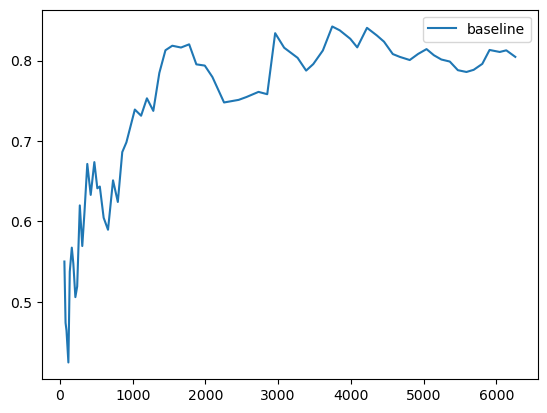

In [38]:
baseline.rename('baseline').plot(legend=True)

In [39]:
me.predict_proba(X_test)

array([0.36184182, 0.63080239, 0.50326673, ..., 0.74417092, 0.32259115,
       0.32490336])

In [42]:
proba_table = X_test[['horse_id']].copy()
proba_table['proba'] = me.predict_proba(X_test)
proba_table

,horse_id,proba
201906040206,5337,0.361842
201906040206,4369,0.630802
201906040206,2921,0.503267
201906040206,2199,0.617855
201906040206,1910,0.224285
...,...,...
201906050809,3105,0.499674
201906050809,7217,0.684267
201906050809,6639,0.744171
201906050809,3185,0.322591


In [43]:
proba_table['R'] = proba_table.index.map(lambda x: str(x)[-2:])
proba_table

,horse_id,proba,R
201906040206,5337,0.361842,06
201906040206,4369,0.630802,06
201906040206,2921,0.503267,06
201906040206,2199,0.617855,06
201906040206,1910,0.224285,06
...,...,...,...
201906050809,3105,0.499674,09
201906050809,7217,0.684267,09
201906050809,6639,0.744171,09
201906050809,3185,0.322591,09


In [44]:
proba_table.groupby('R')['proba'].mean()

R
01    0.356941
02    0.416609
03    0.440954
04    0.433459
05    0.482910
06    0.466754
07    0.498564
08    0.514918
09    0.556804
10    0.539938
11    0.557212
12    0.497603
Name: proba, dtype: float64

# 標準化

In [46]:
X = proba_table.loc['201906040307']['proba']

In [53]:
# 平均
X.mean()

0.5525910330739413

In [54]:
# 分散
X.var()

0.029563309999429955

In [55]:
# 標準偏差
X.std()

0.1719398441299455

In [57]:
X_std = (X-X.mean()) / X.std()
X_std

201906040307    1.578540
201906040307    0.480064
201906040307   -0.095559
201906040307    0.138664
201906040307   -0.664738
201906040307    1.469976
201906040307   -2.352436
201906040307   -0.331706
201906040307   -0.297690
201906040307    0.368100
201906040307    0.457013
201906040307   -0.754789
201906040307    0.004561
Name: proba, dtype: float64

In [59]:
X_std.var()

1.0

## transformとapply

In [60]:
proba_table

,horse_id,proba,R
201906040206,5337,0.361842,06
201906040206,4369,0.630802,06
201906040206,2921,0.503267,06
201906040206,2199,0.617855,06
201906040206,1910,0.224285,06
...,...,...,...
201906050809,3105,0.499674,09
201906050809,7217,0.684267,09
201906050809,6639,0.744171,09
201906050809,3185,0.322591,09


In [64]:
# level0でインデックスでgropuby
proba_table.groupby(level=0)['proba'].transform(np.sum)

201906040206     4.422589
201906040206     4.422589
201906040206     4.422589
201906040206     4.422589
201906040206     4.422589
                  ...    
201906050809    10.059969
201906050809    10.059969
201906050809    10.059969
201906050809    10.059969
201906050809    10.059969
Name: proba, Length: 12870, dtype: float64

In [66]:
standard_scaler = lambda x: (x - x.mean()) / x.std()
proba_table.groupby(level=0)['proba'].transform(standard_scaler)

201906040206   -0.041807
201906040206    1.634662
201906040206    0.839714
201906040206    1.553960
201906040206   -0.899219
                  ...   
201906050809   -0.821303
201906050809    0.353268
201906050809    0.734443
201906050809   -1.948095
201906050809   -1.933382
Name: proba, Length: 12870, dtype: float64

<AxesSubplot:>

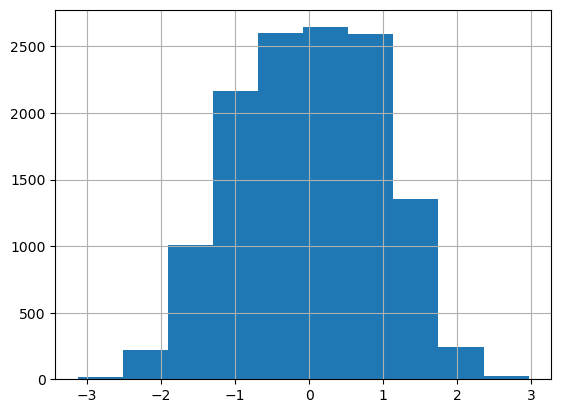

In [ ]:
proba_std = proba_table.groupby(level=0)['proba'].transform(standard_scaler)
proba_std.hist()

標準化はできたけど，今まで作ってきたModelEvaluaterとかは0から1の範囲のものだったから，今回もそうしたいよね

MinMaxスケーリング：データを0から1にする（正規化）

<AxesSubplot:>

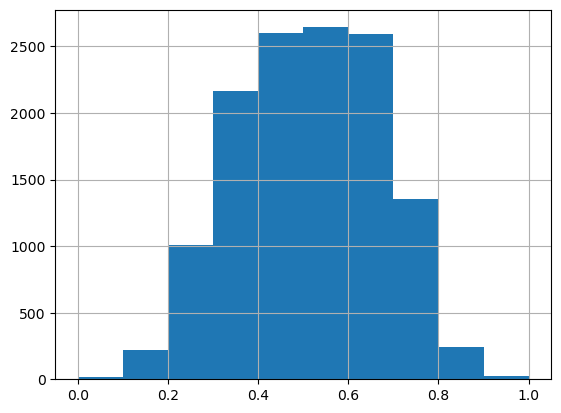

In [68]:
proba_minmax = (proba_std - proba_std.min()) / (proba_std.max() - proba_std.min())
proba_minmax.hist()

## 実装

In [74]:
me = ModelEvaluator(lgb_clf, return_tables, std=True)
gain_std = gain(me.tansho_return, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

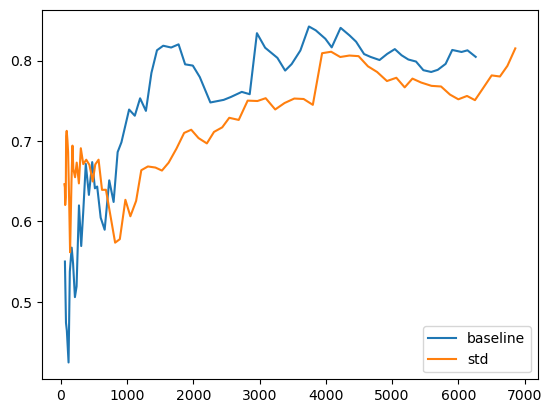

In [75]:
baseline.rename('baseline').plot(legend=True)
gain_std.rename('std').plot(legend=True)

In [119]:
np.sum(me.predict(X_test, threshold=0.8))

271

In [121]:
me.pred_table(X_test, threshold=0.78)

201906040206    12
201906040210     2
201906040211     9
201906040203    13
201906040202     5
                ..
201909050801     5
201909050811     1
201906050807    13
201906050804     5
201906050811     9
Name: 馬番, Length: 430, dtype: int64

In [122]:
_, sample = split_data(results_m)
sample

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
201906040206,1,6,8,54.0,20.5,7.0,2016102450,01025,1800,曇,...,Northern Dancer,Happy Mood,Bold Commander,Dust Storm,Royal Coinage,Our Kretchen,Dr. Fager,Due Dilly,トンピオン,Toast of the Town
201906040206,2,8,12,54.0,1.7,1.0,2016100855,01075,1800,曇,...,Quack,Unsociable,Nearctic,Natalma,Delta Judge,Sand Buggy,Bold Ruler,Somethingroyal,Hoist the Flag,Chris Evert
201906040206,3,6,7,57.0,6.0,2.0,2015103227,01126,1800,曇,...,Luciano,Suleika,Native Dancer,Raise You,Nashua,Sequence,Nearctic,Natalma,Sir Gaylord,Style
201906040206,4,5,5,54.0,86.3,9.0,2014106286,01179,1800,曇,...,Swaps,Portage,Nearctic,Natalma,Victoria Park,Lady Angela,Owen Tudor,Cornice,ヒンドスタン,第五カナデアンガール
201906040206,5,8,11,54.0,53.3,8.0,2014105271,01161,1800,曇,...,Outing Class,Quillopoly,Raise a Native,Gold Digger,Venetian Jester,Friendly Ways,Ribot,Pocahontas,Dewan,Bride of Note
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201906050809,12,1,1,55.0,135.2,15.0,2015104074,01126,1800,曇,...,Shantung,Boulevard,Shirley Heights,Elegant Tern,Sharpen Up,Sultry One,Lyphard,Navajo Princess,Surumu,Prairie Stella
201906050809,13,3,5,54.0,149.6,16.0,2016105305,01051,1800,曇,...,リマンド,イコマエイカン,Northern Dancer,Pas de Nom,His Majesty,Spring Adieu,Northern Dancer,What a Treat,Bold Lad,River Lady
201906050809,14,1,2,54.0,8.3,5.0,2016104596,01032,1800,曇,...,Key to the Mint,Native Partner,Nearctic,Natalma,Victoria Park,Lady Angela,Bubbles,Montagnana,Red God,レデイチヤツター
201906050809,15,6,12,55.0,38.6,11.0,2015104331,00666,1800,曇,...,Grenfall,My Poly,Mill Reef,Hardiemma,Abdos,Kelty,High Top,Sega Ville,Relko,Sursum Corda


In [126]:
bets = sample[['着順', '人気', '単勝', '馬番']].merge(me.pred_table(X_test, threshold=0.78), left_index=True, right_index=True, how='right')

In [127]:
bets

,着順,人気,単勝,馬番_x,馬番_y
201903030102,1,4.0,8.0,1,14
201903030102,2,1.0,2.7,14,14
201903030102,3,8.0,17.4,10,14
201903030102,4,6.0,12.3,3,14
201903030102,5,2.0,5.5,9,14
...,...,...,...,...,...
201909050811,9,7.0,16.4,5,1
201909050811,10,11.0,141.6,10,1
201909050811,11,10.0,42.6,6,1
201909050811,12,9.0,31.0,3,1


In [130]:
bets[bets['馬番_x'] == bets['馬番_y']]['人気'].value_counts()

1.0     155
2.0      86
3.0      51
4.0      35
5.0      26
7.0      18
6.0      16
8.0      11
10.0      7
9.0       6
11.0      6
12.0      4
13.0      4
14.0      3
18.0      1
16.0      1
Name: 人気, dtype: int64

In [132]:
bets[(bets['馬番_x'] == bets['馬番_y']) & (bets['着順'] == 1)]['人気'].value_counts()

1.0    56
2.0    16
3.0     5
4.0     3
7.0     2
6.0     1
5.0     1
Name: 人気, dtype: int64

In [133]:
len(bets[(bets['馬番_x'] == bets['馬番_y']) & (bets['着順'] == 1)])

84

In [134]:
84/271

0.30996309963099633

In [142]:
len(sample[sample['人気']==1])

954

In [143]:
len(sample[(sample['人気']==1) & (sample['着順'] == 1)])

316

In [144]:
rt = Return(return_tables)
rt.tansho

,win,return
201906040209,5.0,150.0
201906040204,4.0,540.0
201909040212,15.0,270.0
201906040205,7.0,200.0
201906040210,8.0,500.0
...,...,...
201909050811,11.0,1510.0
201909050810,5.0,590.0
201909050812,10.0,600.0
201909050808,13.0,350.0


In [145]:
bets = rt.tansho.merge(me.pred_table(X_test, threshold=0.78), left_index=True, right_index=True, how='right')
bets

,win,return,馬番
201903030102,1.0,800.0,14
201903030104,13.0,6480.0,6
201903030105,1.0,490.0,4
201903030105,1.0,490.0,7
201903030108,6.0,240.0,11
...,...,...,...
201909050712,13.0,1450.0,6
201909050801,10.0,2220.0,5
201909050802,10.0,290.0,10
201909050805,3.0,240.0,3


In [147]:
wins = bets[bets['win'] == bets['馬番']]
wins

,win,return,馬番
201903030305,9.0,190.0,9
201904030107,6.0,310.0,6
201904030208,6.0,430.0,6
201904030304,9.0,230.0,9
201904030402,9.0,470.0,9
...,...,...,...
201909050309,9.0,460.0,9
201909050401,8.0,180.0,8
201909050711,5.0,210.0,5
201909050802,10.0,290.0,10


<AxesSubplot:>

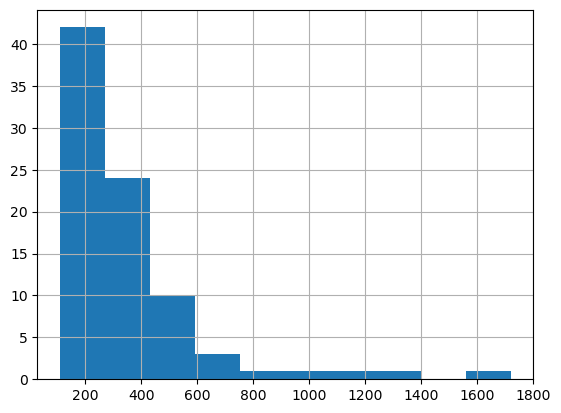

In [148]:
wins['return'].hist()

In [149]:
wins['return'].sum() - 100*271

1720.0

# 2020年のデータ追加

In [218]:
race_id_list = []
for place in range(1, 11, 1):
    for kai in range(1, 7, 1):
        for day in range(1, 13, 1):
            for r in range(1, 13, 1):
                race_id = "2023" + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(r).zfill(2)
                race_id_list.append(race_id)

results = Results.scrape(race_id_list)


  0%|          | 0/8640 [00:00<?, ?it/s]

('Connection aborted.', TimeoutError(60, 'Operation timed out'))


In [185]:
results.to_pickle('results_2020.pickle')

In [187]:
race_id_list = results.index.unique()

In [ ]:
horse_id_list = results['horse_id'].unique()
horse_results = HorseResults.scrape(horse_id_list)
horse_results #jupyterで出力

In [194]:
fin_horse_id = horse_results.index.unique()

In [196]:
def find_unique_values(list1, list2):
    unique_values = []
    for value in list1:
        if value not in list2:
            unique_values.append(value)
    return unique_values

mada = find_unique_values(horse_id_list, fin_horse_id)

In [199]:
horse_results_add = HorseResults.scrape(mada)

  0%|          | 0/3735 [00:00<?, ?it/s]

In [202]:
horse_id_list = results['horse_id'].unique()
peds = Peds.scrape(horse_id_list)
peds

  0%|          | 0/11702 [00:00<?, ?it/s]

<urlopen error [Errno 8] nodename nor servname provided, or not known>


,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2018101626,ゴールドシップ 2009 芦毛 [血統][産駒] Halo系,コスモエルデスト 2011 鹿毛 [血統][産駒] FNo.[14-f],ステイゴールド 1994 黒鹿毛 [血統][産駒],ポイントフラッグ 1998 芦毛 [血統][産駒],ブラックホーク 1994 鹿毛 [血統][産駒],ビューティアイ 2005 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ゴールデンサッシュ 1988 栗毛 [血統][産駒],メジロマックイーン 1987 芦毛 [血統][産駒],パストラリズム 1987 黒鹿毛 [血統][産駒],...,Chieftain,Level Sands,Halo,Wishing Well,Carr de Naskra,Mawgrit,Danzig,Razyana,リアルシャダイ,マックスビューティ
2018105193,ディープインパクト 2002 鹿毛 [血統][産駒] Halo系,ヒストリックスター 2005 鹿毛 [血統][産駒] FNo.[9-f],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ウインドインハーヘア Wind in Her Hair(愛) 1991 鹿毛 [血統][産駒],ファルブラヴ Falbrav(愛) 1998 鹿毛 [血統][産駒],ベガ 1990 鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],Alzao 1980 鹿毛 [血統][産駒],Burghclere 1977 鹿毛 [血統][産駒],...,Lithiot,Nenana Road,Kalamoun,State Pension,Hornbeam,Priddy Fair,Nearctic,Natalma,Tom Fool,Brazen
2018104800,スクリーンヒーロー 2004 栗毛 [血統][産駒] Roberto系,マルバイユ Marbye(愛) 2000 鹿毛 [血統][産駒] FNo.[9-f],グラスワンダー 1995 栗毛 [血統][産駒],ランニングヒロイン 1993 鹿毛 [血統][産駒],Marju 1988 黒鹿毛 [血統][産駒],Hambye 1994 鹿毛 [血統][産駒],Silver Hawk 1979 鹿毛 [血統][産駒],Ameriflora 1989 鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ダイナアクトレス 1983 鹿毛 [血統][産駒],...,Welsh Pageant,Electric Flash,Sir Gaylord,Little Hut,Claude,Ribasha,Thatch,Last Call,Mummy's Pet,Goosie-Gantlet
2018102410,キズナ 2010 青鹿毛 [血統][産駒] Halo系,ヴィアレッタ 2011 鹿毛 [血統][産駒] FNo.[14-c],ディープインパクト 2002 鹿毛 [血統][産駒],キャットクイル Catequil(加) 1990 鹿毛 [血統][産駒],Pivotal 1993 栗毛 [血統][産駒],ヴァレッタ Valletta(英) 2006 鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ウインドインハーヘア Wind in Her Hair(愛) 1991 鹿毛 [血統][産駒],Storm Cat (米) 1983 黒鹿毛 [血統][産駒],Pacific Princess 1973 鹿毛 [血統][産駒],...,Bustino,Zerbinetta,Danzig,Foreign Courier,Ahonoora,Balidaress,Arctic Tern,Beaune,Nureyev,Unite
2018100828,リオンディーズ 2013 黒鹿毛 [血統][産駒] Mr. Prospector系,スマートエンデバー 2010 栗毛 [血統][産駒] FNo.[12-c],キングカメハメハ 2001 鹿毛 [血統][産駒],シーザリオ 2002 青毛 [血統][産駒],ファルブラヴ Falbrav(愛) 1998 鹿毛 [血統][産駒],ディスコホール 1989 栗毛 [血統][産駒],Kingmambo (米) 1990 鹿毛 [血統][産駒],マンファス Manfath(愛) 1991 黒鹿毛 [血統][産駒],スペシャルウィーク 1995 黒鹿毛 [血統][産駒],キロフプリミエール Kirov Premiere(英) 1990 鹿毛 [血統][産駒],...,Lithiot,Nenana Road,Nearctic,Natalma,Victoria Park,Lady Angela,Herbager,Silver Sari,Crimson Satan,Bright Prospect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017101353,ストロングリターン 2006 鹿毛 [血統][産駒] Roberto系,イヴニングミスト Evening Mist(米) 2000 鹿毛 [血統][産駒] FNo....,シンボリクリスエス 1999 黒鹿毛 [血統][産駒],コートアウト Caught Out(米) 1998 鹿毛 [血統][産駒],Pulpit 1994 鹿毛 [血統][産駒],Next Fall 1984 鹿毛 [血統][産駒],Kris S. 1977 黒鹿毛 [血統][産駒],Tee Kay 1991 黒鹿毛 [血統][産駒],Smart Strike (加) 1992 鹿毛 [血統][産駒],アザール Azhaar(米) 1991 栗毛 [血統][産駒],...,Honest Pleasure,State,Tom Rolfe,Wavy Navy,Prince John,Determined Lady,Northern Dancer,Flaming Page,Crozier,Hillbrook
2017110174,Emcee 2008 鹿毛 [血統][産駒] Mr. Prospector系,Cowgirl Lucky 2004 黒鹿毛 [血統][産駒] FNo.[3-j],Unbridled's Song (米) 1993 芦毛 [血統][産駒],Surf Club 1998 鹿毛 [血統][産駒],Stephen Got Even 1996 鹿毛 [血統][産駒],Energise 1993 黒鹿毛 [血統][産駒],Unbridled 1987 鹿毛 [血統][産駒],Trolley Song 1983 芦毛 [血統][産駒],Ocean Crest 1991 黒鹿毛 [血統][産駒],Horns Gray 1991 芦毛 [血統][産駒],...,Blushing Groom,Avum,Raise a Native,Gold Digger,Buckpasser,Intriguing,Halo,Ballade,Nijinsky,Rosetta Stone
2017102147,ローレルゲレイロ 2004 青鹿毛 [血統][産駒] Lyphard系,キセキノショウリ 2011 黒鹿毛 [血統][産駒] FNo.[9-f],キングヘイロー 1995 鹿毛 [血統][産駒],ビッグテンビー 1998 黒鹿毛 [血統][産駒],フジキセキ 1992 青鹿毛 [血統][産駒],サマーベイブ 1997 黒鹿毛 [血統][産駒],ダンシングブレーヴ Dancing Brave(米) 1983 鹿毛 [血統][産駒],グッバイヘイロー Goodbye Halo(米) 1985 栗毛 [血統][産駒],テンビー Tenby(英) 1990 鹿毛 [血統][産駒],モガミヒメ 1992 黒鹿毛 [血統][産駒],...,In Reality,Millicent,Kalamoun,State Pension,Hornbeam,Priddy Fair,Northern Dancer,Lady Victoria,シーホーク,ファンシミン
2017106232,ルーラーシップ 2007 鹿毛 [血統][産駒] Mr. Prospector系,メロウメロディ 2008 鹿毛 [血統][産駒] FNo.[4-m],キングカメハメハ 2001 鹿毛 [血統][産駒],エアグルーヴ 1993 鹿毛 [血統][産駒],キャプテンスティーヴ Captain Steve(米) 1997 栃栗毛 [血統][産駒],シスタースルー 1992 鹿毛 [血統][産駒],Kingmambo (米) 1990 鹿毛 [血統]

In [203]:
fin_horse_id = peds.index.unique()

In [206]:
mada = find_unique_values(horse_id_list, fin_horse_id)

peds_add = Peds.scrape(mada)

  0%|          | 0/5729 [00:00<?, ?it/s]

In [212]:
race_id_list = results.index.unique()
return_table = Return.scrape(race_id_list)

  0%|          | 0/3456 [00:00<?, ?it/s]